# **GSoC 2024 QMLHEP Task VI**
---

## **Quantum Representation Learning**
In this task I tried to implement a simple representation learning scheme based on a contrastive loss following these steps:

* Load the MNIST dataset
* Write a function which takes an image and prepares a quantum state. This function should have trainable parameters which we want to learn in order to have good quantum representations
* Create a circuit with which takes two images and embeds both as quantum states with the function you wrote before. Afterwards the circuit should perform a SWAP test between the two states. In the end the measurement should give the fidelity of the quantum states.
* Train the circuit parameters with a contrastive loss: For two MNIST images in the same class the fidelity should be maximized, while for images of different classes the fidelity should be minimized.

### **Resources**
* [Xanadu Codebook](https://codebook.xanadu.ai/I.13)


In [1]:
import tensorflow as tf
import pennylane as qml
import cv2
import jax
from jax import numpy as jnp
import optax
import numpy as np
import matplotlib.pyplot as plt

---
# **Loading data**
---

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


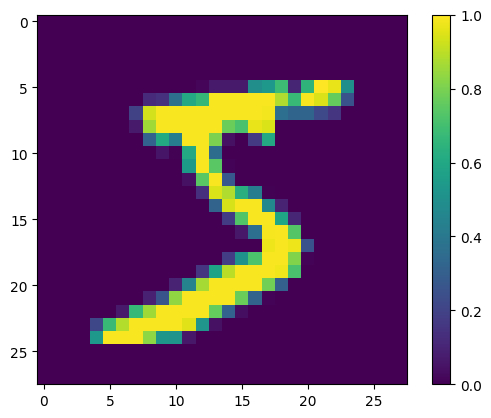

In [3]:
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

---
# **Quantum encoding**
---

Operating with 784 qubits it is currently unfeasible. Thus, in this works geometric features of the images as their binary areas, parimeters, width and height was calculated, in order to use them to enconde each image as a quantum circuit

In [4]:
def binary_img(imgs):
  bin = imgs > 0
  return bin

def binary_area(imgs):
  areas = np.sum(imgs, axis=(1, 2, 3))

  return areas

def binary_perimeter(imgs):
  perims = np.sum(np.diff(imgs, axis=1), axis=(1, 2, 3)) + np.sum(np.diff(imgs, axis=2), axis=(1, 2, 3))

  return perims

def binary_width(imgs):
  widths = np.max(np.sum(imgs, axis=2), axis=1)

  return widths

def binary_height(imgs):
  widths = np.max(np.sum(imgs, axis=1), axis=1)

  return widths

In [5]:
def feature_extraction(imgs):
  """Extract geometrical feature of the images"""
  binary = binary_img(imgs)
  areas = binary_area(binary).reshape(60000, 1)
  perimeters = binary_perimeter(binary).reshape(60000, 1)
  width = binary_width(binary).reshape(60000, 1)
  height = binary_height(binary).reshape(60000, 1)

  return np.concatenate((areas[:], perimeters[:], width[:], height[:]), axis=1)

In [6]:
features_train = feature_extraction(x_train)

In [7]:
def make_pairs(images, labels):

	pairImages = []
	pairLabels = []

	numClasses = len(np.unique(labels))
	idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
	# loop over all images
	for idxA in range(len(images)):

		currentImage = images[idxA]
		label = labels[idxA]

		idxB = np.random.choice(idx[label])
		posImage = images[idxB]

		pairImages.append([currentImage, posImage])
		pairLabels.append([1])

		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]

		pairImages.append([currentImage, negImage])
		pairLabels.append([0])

	return (np.array(pairImages), np.array(pairLabels))

### Encoding function
---
To encode each images, their geometrical features was takes as a qubit, and a Pauli-Y rotation was applied on each based on the value of their respective feature. Then a series of rotation followed by an entanglement operation were applied to each circuit, this rotations has trainable parameters

In [8]:
def prepare_state(image, weights, n_img=0):
  """Encode truncated classical image into quantum datapoint."""

  for i in range(4):
      qml.RY(image[i], wires=i+4*n_img)

  for i in range(4):
      qml.RX(weights[i, 0], wires=i+4*n_img)
      qml.RY(weights[i, 1], wires=i+4*n_img)
      qml.RX(weights[i, 2], wires=i+4*n_img)
      if i < 3:
        qml.CNOT(wires=[i+4*n_img, (i+4*n_img + 1)])

In [9]:
# take a set of 100 samples and creates pairs
pair_imgs, pair_labels = make_pairs(features_train[:50], y_train[:50])
pair_imgs = jnp.array(pair_imgs)

### Swap test
---

Once defined the encoding function, the following circuit takes a pair of images, encode them as a single quantum circuit and perform a swap test between the images states. the circuit's output is the probabilities of the ancilla qubit, which represents the fidelity of the circuit

In [10]:
n_wires = 9
dev = qml.device("default.qubit", wires=n_wires)

@qml.qnode(dev)
def swap_test(imgs, weights):
  """Applies a swap test between the encoded images"""
  img_1 = prepare_state(imgs[:][0], weights)
  img_2 = prepare_state(imgs[:][1], weights, n_img=1)

  # Performs swap test
  qml.Hadamard(wires = 8)
  for i in range(4):
    qml.CSWAP(wires= [8, i, i+4])
  qml.Hadamard(wires = 8)

  return qml.probs(wires=8)

In [11]:
weights = jnp.ones([4, 3])

(<Figure size 2400x1000 with 1 Axes>, <Axes: >)


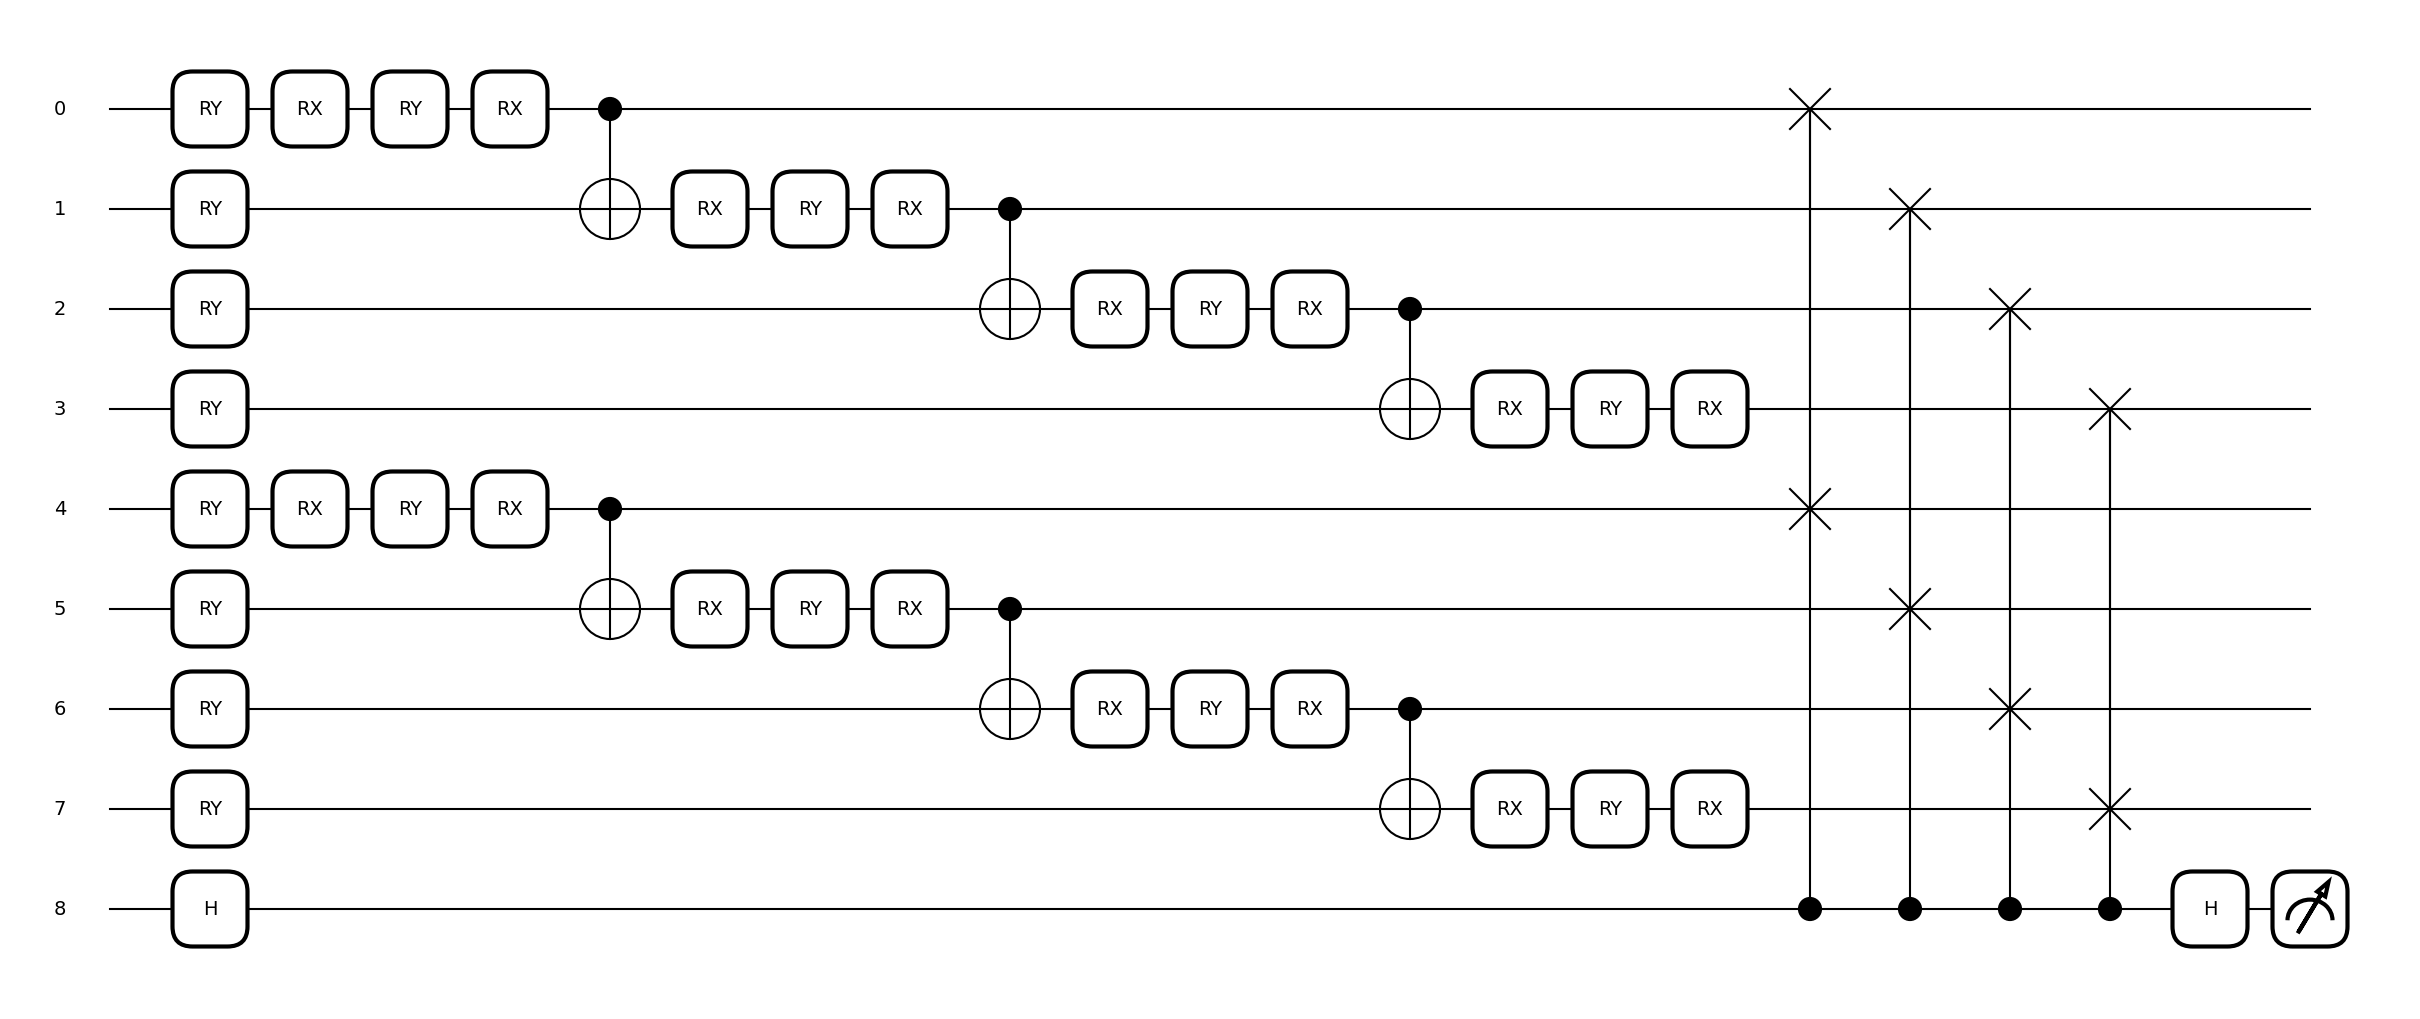

In [12]:
# Print the swap test circuit
drawer = qml.draw_mpl(swap_test)(pair_imgs[0], weights)
print(drawer)

---
# ***Training***
---
To train the parameters of the circuit, a contrastive loss is going to be used:

$$
\text{Loss} = \text{Y}*\text{P}(1) + (1 - \text{Y})*max(0, 0.5 - \text{P}(1))
$$

where Y is the label of the pair, it will be 1 when the images belongs to the same class and 0 when they don not belong to the same class and P(1) is the probability of measure the $\left|1 \right\rangle$. The goal es minimize the function, in other words, adjut the parameters in a such way that when the images belong to the same class $\text{P}(1)=0$, and when they do not, then $\text{P}(1)=0.5$. This is done by the swap test, because if the two quanum images encoding are 'close' to each other (belong to the same class), then the swap test returns a high fidelity, the opposite happens when the pair of images do not belong to the same class.

In [13]:
def model(imgs, weights):
  return swap_test(imgs, weights)

In [14]:
@jax.jit
def contrastive_loss(weights, pair_imgs, pair_labels):
  contrastive_loss = []

  for i, pair in enumerate(pair_imgs):
    probs_1 = model(pair, weights)[1]
    contrastive_loss.append((pair_labels[i]*probs_1)+((1-pair_labels[0])*jax.numpy.maximum(0, 0.5-probs_1)))

  return jax.numpy.mean(jax.numpy.stack(contrastive_loss))


In [17]:
contrastive_loss(weights, pair_imgs[:5], pair_labels[:5])

Array(0.08867741, dtype=float32)

In [18]:
opt = optax.adam(learning_rate=0.3)
opt_state = opt.init(weights)

In [19]:
def update_step(opt, weights, opt_state, pair_imgs, pair_labels):
  loss_val, grads = jax.value_and_grad(contrastive_loss)(weights, pair_imgs[:10], pair_labels[:10])
  updates, opt_state = opt.update(grads, opt_state)
  weights = optax.apply_updates(weights, updates)
  return weights, opt_state, loss_val

loss_history = []

for i in range(100):
  weights, opt_state, loss_val = update_step(opt, weights, opt_state, pair_imgs, pair_labels)

  if i % 5 == 0:
    print(f"step: {i} Loss: {loss_val}")

step: 0 Loss: 0.06226102262735367
step: 5 Loss: 0.06226104125380516
step: 10 Loss: 0.06226104497909546
step: 15 Loss: 0.06226107105612755
step: 20 Loss: 0.062261033803224564
step: 25 Loss: 0.062261033803224564
step: 30 Loss: 0.06226104497909546
step: 35 Loss: 0.062261052429676056
step: 40 Loss: 0.062261033803224564
step: 45 Loss: 0.06226106360554695
step: 50 Loss: 0.06226104497909546
step: 55 Loss: 0.06226104125380516
step: 60 Loss: 0.06226104125380516
step: 65 Loss: 0.062261033803224564
step: 70 Loss: 0.06226104497909546
step: 75 Loss: 0.062261033803224564
step: 80 Loss: 0.062261033803224564
step: 85 Loss: 0.062261052429676056
step: 90 Loss: 0.06226102635264397
step: 95 Loss: 0.06226106360554695


---
# ***Results***
---
Unfortunatly, even with a batch of 100 samples, the training last too much time, when the training is performed with a batch of 10 samples it finish but do not train, this could be due to the very few samples or due to the implementation of the quantum encoding.



---
# ***Further Work***
---

This work had not given the desired results, this implementation can be improved by trying different quantum encodings, optimizing the current implementation in order to be able to train it with a dataset of a considerable size and considering different ways of optimizing, using other algorithms and aproaches.